In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [2]:
# =============================
# BLOQUE 1: IMPORTS Y CONFIGURACIÓN GENERAL
# =============================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import random
import kagglehub
import keras_tuner as kt
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
plt.rcParams["figure.figsize"] = (6, 6)

dataset_path = kagglehub.dataset_download(
    "agungpambudi/mnist-multiple-dataset-comprehensive-analysis",
    force_download=True # Set to True to force download even if it exists
)

base_path = Path(dataset_path) / "PolyMNIST"
assert base_path.exists(), f"No se encontró la ruta: {base_path}"

# Ejercicio 1

🔍 Explorando estructura de carpetas:

 Carpeta: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST
   Subcarpeta: MMNIST

 Carpeta: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST
   Subcarpeta: test
   Subcarpeta: train

 Carpeta: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test
   Subcarpeta: m4
   Subcarpeta: m2
   Subcarpeta: m0
   Subcarpeta: m1
   Subcarpeta: m3

 Carpeta: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4
   Archivo: 428.0.png
   Archivo: 41.7.png
   Archivo: 654.5.png
   Archivo: 604.7.png
   Archivo: 740.0.png
   Archivo: 188.3.png
   Archivo: 541.8.png
   Archivo: 160.8.png
   Archivo: 908.2.png
   Archivo: 840.8.png

 Carpeta: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m2
   Archivo: 428.0.png
   Archivo: 41.7.png
   Archivo: 654.5.png
   Archivo: 604.7.png
   Archivo: 740.0.png
   Archivo: 188.3.png
   Arc

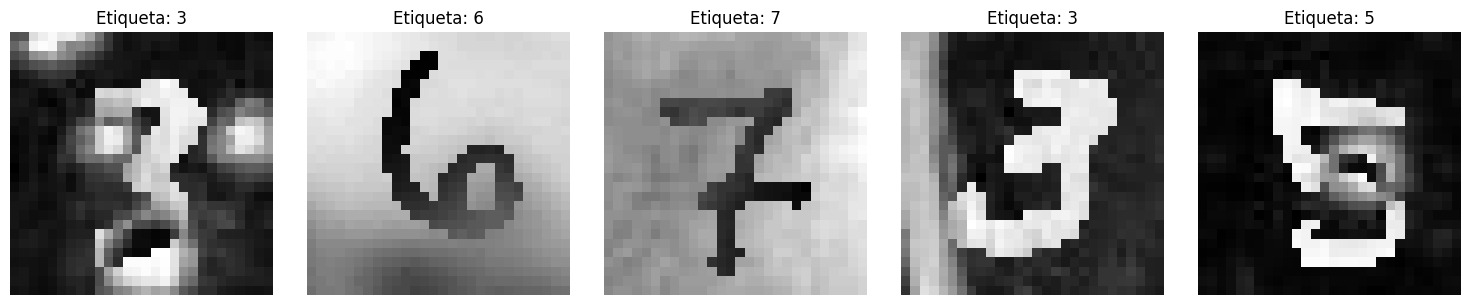

In [4]:
# =============================
# BLOQUE 1 - MOSTRAR EJEMPLOS DE CADA MODALIDAD
# =============================

print("🔍 Explorando estructura de carpetas:")
for root, dirs, files in os.walk(base_path):
    print(f"\n Carpeta: {root}")
    for d in dirs:
        print(f"   Subcarpeta: {d}")
    for f in files[:10]:
        print(f"   Archivo: {f}")

modalities = sorted([d for d in base_path.glob("*") if d.is_dir()])
print("\nModalidades encontradas:", [m.name for m in modalities])

n_samples = 5

for modality_path in modalities:
    images = list(modality_path.rglob("*.png"))
    num_images = len(images)
    print(f"\n {modality_path.name} contiene {num_images} imágenes")

    if num_images == 0:
        print(f" {modality_path.name} está vacía o no contiene archivos .png.")
        continue

    sampled_images = random.sample(images, min(n_samples, num_images))

    print(f" Mostrando ejemplos de: {modality_path.name}")
    plt.figure(figsize=(15, 3))

    for i, img_path in enumerate(sampled_images):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f" No se pudo leer la imagen: {img_path}")
            continue
        plt.subplot(1, len(sampled_images), i + 1)
        plt.imshow(img, cmap='gray')
        try:
            label = img_path.name.split(".")[1]
        except IndexError:
            label = "¿?"
        plt.title(f"Etiqueta: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Ejercicio 2

In [5]:
# =============================
# BLOQUE 2.1 - RESUMEN GENERAL POR MODALIDAD
# =============================

modality_summary = []

for modality_path in modalities:
    images = list(modality_path.rglob("*.png"))
    modality_summary.append({
        "Modalidad": modality_path.name,
        "Cantidad de imágenes": len(images)
    })

df_summary = pd.DataFrame(modality_summary)
print("Cantidad de imágenes por modalidad:")
display(df_summary)

Cantidad de imágenes por modalidad:


,Modalidad,Cantidad de imágenes
0,MMNIST,350000


In [6]:
# =============================
# BLOQUE 2.2 - RESOLUCIÓN DE LAS IMÁGENES
# =============================

# Tomar algunas imágenes al azar para verificar resoluciones
sample_images = []

for modality_path in modalities:
    all_images = list(modality_path.rglob("*.png"))
    if all_images:
        sample_images.append(random.choice(all_images))

resolutions = []

for img_path in sample_images:
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        resolutions.append(img.shape)

print("Resoluciones encontradas en imágenes de muestra:")
for path, res in zip(sample_images, resolutions):
    print(f"{path.name} -> {res}")

# Comprobación si todas son iguales
if len(set(resolutions)) == 1:
    print("Todas las imágenes tienen la misma resolución:", resolutions[0])
else:
    print("Se encontraron imágenes con distintas resoluciones.")

Resoluciones encontradas en imágenes de muestra:
4923.2.png -> (28, 28)
Todas las imágenes tienen la misma resolución: (28, 28)


In [7]:
# =============================
# BLOQUE 2.3 - DISTRIBUCIÓN DE CLASES
# =============================

from collections import Counter

label_counts = {}

for modality_path in modalities:
    label_list = []
    images = list(modality_path.rglob("*.png"))
    for img_path in images:
        try:
            label = img_path.name.split(".")[1]
            label_list.append(label)
        except IndexError:
            continue

    counter = Counter(label_list)
    label_counts[modality_path.name] = counter

# Convertir a DataFrame para visualizar
df_distribution = pd.DataFrame(label_counts).fillna(0).astype(int)
df_distribution.index.name = "Etiqueta"
print("Distribución de etiquetas por modalidad:")
display(df_distribution)

Distribución de etiquetas por modalidad:


,MMNIST
Etiqueta,
0,34515
7,36465
5,31565
3,35705
8,34125
2,34950
4,34120
6,34380
1,39385


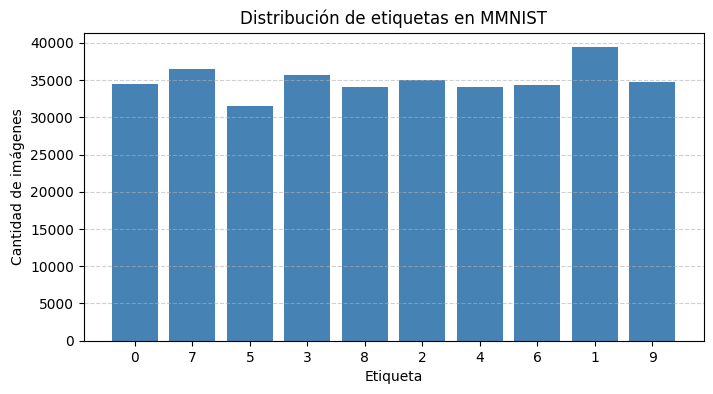

In [8]:
# =============================
# BLOQUE 2.4 - VISUALIZACIÓN DE DISTRIBUCIÓN DE CLASES
# =============================

for modality, counts in label_counts.items():
    labels = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(8, 4))
    plt.bar(labels, values, color='steelblue')
    plt.title(f"Distribución de etiquetas en {modality}")
    plt.xlabel("Etiqueta")
    plt.ylabel("Cantidad de imágenes")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

# Ejercicio 3

* Primero Modelo CNN

Train: 1800 imágenes
Validation: 600 imágenes
Test: 600 imágenes
Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 519ms/step - accuracy: 0.1037 - loss: 2.3057 - val_accuracy: 0.1367 - val_loss: 2.2945
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 520ms/step - accuracy: 0.1935 - loss: 2.2133 - val_accuracy: 0.4200 - val_loss: 1.7058
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 516ms/step - accuracy: 0.4773 - loss: 1.5466 - val_accuracy: 0.6400 - val_loss: 1.1274
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.6732 - loss: 1.0004 - val_accuracy: 0.7750 - val_loss: 0.7287
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 534ms/step - accuracy: 0.8035 - loss: 0.6131 - val_accuracy: 0.8200 - val_loss: 0.5786
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


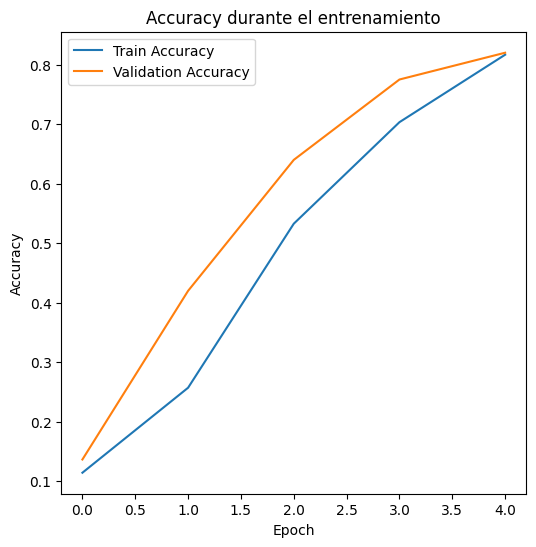

----------------------------------------------------------------------------------------------------


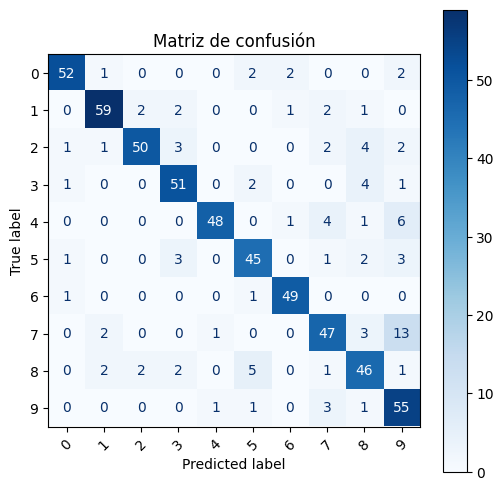

In [9]:
# =============================
# BLOQUE 3.1 - VISUALIZACIÓN DE DISTRIBUCIÓN DE CLASES
# =============================
def load_images_and_labels(base_path, max_images=5000):
    images, labels = [], []
    count = 0
    png_paths = list(base_path.rglob("*.png"))[:max_images]  # Limita búsqueda directamente

    for img_path in png_paths:
        if count >= max_images:
            break
        try:
            label = int(img_path.name.split('.')[1])
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None and img.shape == (28, 28):  # evita redimensionar si ya está bien
                images.append(img)
                labels.append(label)
                count += 1
        except:
            continue

    return np.array(images), np.array(labels)

# Cargar datos (con tope de imágenes para hacerlo más rápido)
images, labels = load_images_and_labels(base_path, max_images=3000)

# Normalizar y reordenar dimensiones
images = images.astype("float32") / 255.0
images = images.reshape(-1, 28, 28, 1)
labels_cat = to_categorical(labels, num_classes=10)

# División en train, val, test
X_temp, X_test, y_temp, y_test = train_test_split(images, labels_cat, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=np.argmax(y_temp, axis=1))

print(f"Train: {len(X_train)} imágenes")
print(f"Validation: {len(X_val)} imágenes")
print(f"Test: {len(X_test)} imágenes")

# Modelo CNN
def model_builder(input_shape=(28, 28, 1), num_classes=10):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

modelo1_CNN = model_builder()

# Entrenar con batch_size más grande para acelerar
history = modelo1_CNN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64,  # acelerar entrenamiento
    verbose=1
)
modelo1_history = history
# Predicción y métricas
y_pred_probs = modelo1_CNN.predict(X_test)
y_pred1 = np.argmax(y_pred_probs, axis=1)



plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("-"*100)

y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de confusión")
plt.show()

* Modelo 2 CNN

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.1149 - loss: 2.2951 - val_accuracy: 0.3817 - val_loss: 2.0277
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.4005 - loss: 1.8209 - val_accuracy: 0.6050 - val_loss: 1.2715
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.6025 - loss: 1.2312 - val_accuracy: 0.7250 - val_loss: 0.9475
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.7431 - loss: 0.8838 - val_accuracy: 0.7650 - val_loss: 0.7412
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.8174 - loss: 0.6471 - val_accuracy: 0.8183 - val_loss: 0.5921
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


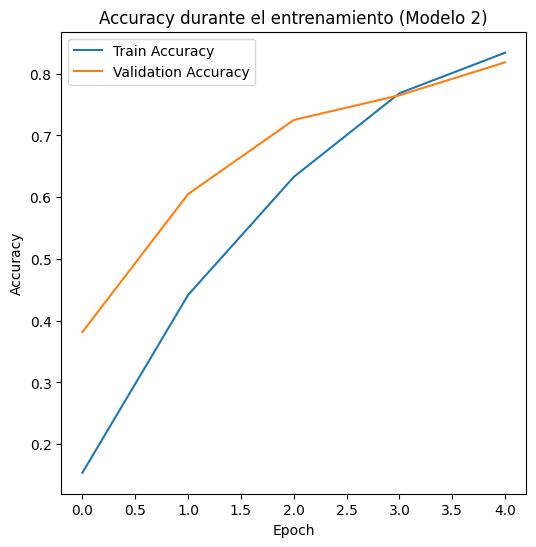

----------------------------------------------------------------------------------------------------


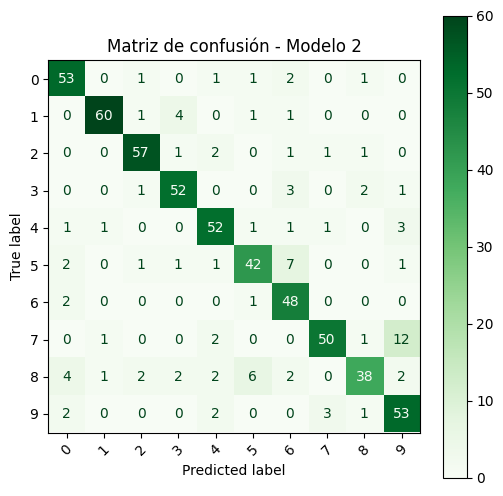

In [10]:
# =============================
# BLOQUE 3.2 - VISUALIZACIÓN DE DISTRIBUCIÓN DE CLASES Modelo 2
# =============================

def model_builder_v2(input_shape=(28, 28, 1), num_classes=10):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))

    # Bloque 1 - Menos filtros
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Bloque 2 - Más regularización
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))  # Segundo pooling

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.3))  # Regularización

    # Capas densas distintas
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='tanh'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Construcción del modelo
modelo2_CNN = model_builder_v2()

# Entrenamiento
history = modelo2_CNN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64,
    verbose=1
)


modelo2_history = history
# Evaluación
y_pred_probs = modelo2_CNN.predict(X_test)
y_pred2 = np.argmax(y_pred_probs, axis=1)

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento (Modelo 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("-"*100)

# Matriz de confusión
y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title("Matriz de confusión - Modelo 2")
plt.show()


Comparacion y efectividad Modelos

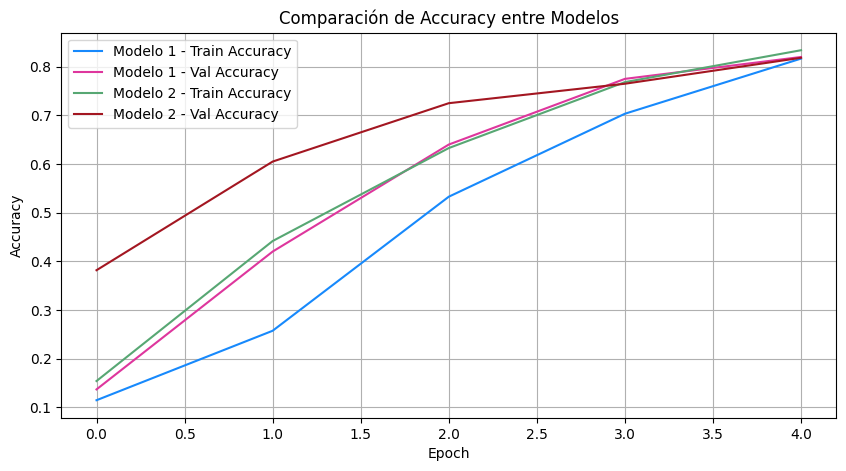

Modelo 1 - Accuracy Test: 0.8367
Modelo 2 - Accuracy Test: 0.8417
Reporte - Modelo 1
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        59
           1       0.91      0.88      0.89        67
           2       0.93      0.79      0.85        63
           3       0.84      0.86      0.85        59
           4       0.96      0.80      0.87        60
           5       0.80      0.82      0.81        55
           6       0.92      0.96      0.94        51
           7       0.78      0.71      0.75        66
           8       0.74      0.78      0.76        59
           9       0.66      0.90      0.76        61

    accuracy                           0.84       600
   macro avg       0.85      0.84      0.84       600
weighted avg       0.85      0.84      0.84       600


Reporte - Modelo 2
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        59
           1       0.95    

In [11]:
#===========================
#3.3 Comparación de modelos
#===========================

plt.figure(figsize=(10, 5))
plt.plot(modelo1_history.history['accuracy'], label='Modelo 1 - Train Accuracy', linestyle='-',color="#1789FC")
plt.plot(modelo1_history.history['val_accuracy'], label='Modelo 1 - Val Accuracy', linestyle='-',color = "#DE369D")
plt.plot(modelo2_history.history['accuracy'], label='Modelo 2 - Train Accuracy', linestyle='-',color="#57A773")
plt.plot(modelo2_history.history['val_accuracy'], label='Modelo 2 - Val Accuracy', linestyle='-',color="#A31621")
plt.title('Comparación de Accuracy entre Modelos')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

loss1, acc1 = modelo1_CNN.evaluate(X_test, y_test, verbose=0)
loss2, acc2 = modelo2_CNN.evaluate(X_test, y_test, verbose=0)

print("Modelo 1 - Accuracy Test:", round(acc1, 4))
print("Modelo 2 - Accuracy Test:", round(acc2, 4))

print("Reporte - Modelo 1")
print(classification_report(y_test_classes, y_pred1))

print("\nReporte - Modelo 2")
print(classification_report(y_test_classes, y_pred2))


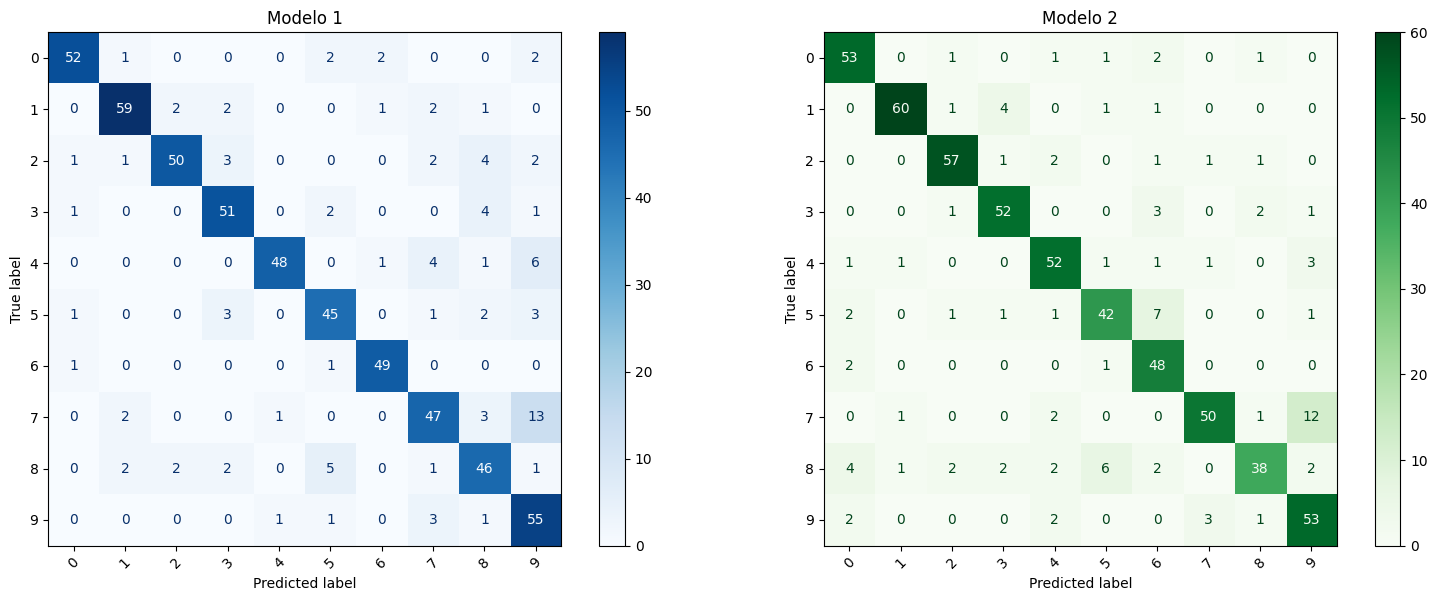

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cm1 = confusion_matrix(y_test_classes, y_pred1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=[str(i) for i in range(10)])
disp1.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title("Modelo 1")

cm2 = confusion_matrix(y_test_classes, y_pred2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[str(i) for i in range(10)])
disp2.plot(ax=axes[1], cmap='Greens', xticks_rotation=45)
axes[1].set_title("Modelo 2")

plt.tight_layout()
plt.show()

# Ejercicio 4

Epoch 1/128
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1148 - loss: 2.3824 - val_accuracy: 0.1200 - val_loss: 2.3262
Epoch 2/128
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1056 - loss: 2.3087 - val_accuracy: 0.1083 - val_loss: 2.3076
Epoch 3/128
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1321 - loss: 2.2923 - val_accuracy: 0.1317 - val_loss: 2.3008
Epoch 4/128
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1572 - loss: 2.2761 - val_accuracy: 0.1333 - val_loss: 2.2973
Epoch 5/128
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1810 - loss: 2.2643 - val_accuracy: 0.1767 - val_loss: 2.2904
Epoch 6/128
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1884 - loss: 2.2489 - val_accuracy: 0.1583 - val_loss: 2.2807
Epoch 7/128
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2124 - loss: 2.2224 - val_accuracy: 0.1700 - val_loss: 2.2672
Epoch 8/128
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2274 - loss: 2.1900 - val_accuracy: 0.1833 - 

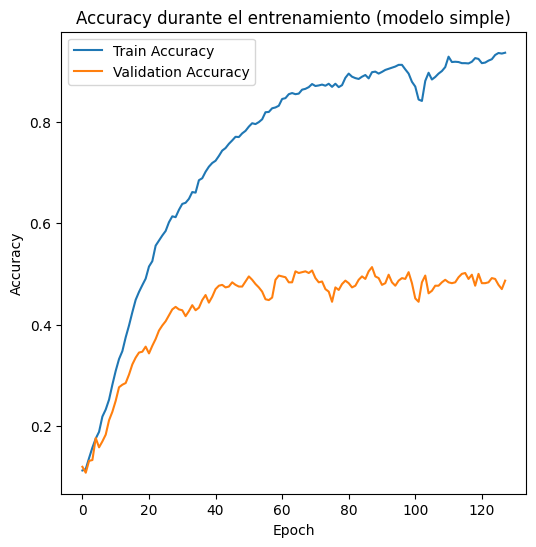

--------------------------------------------------


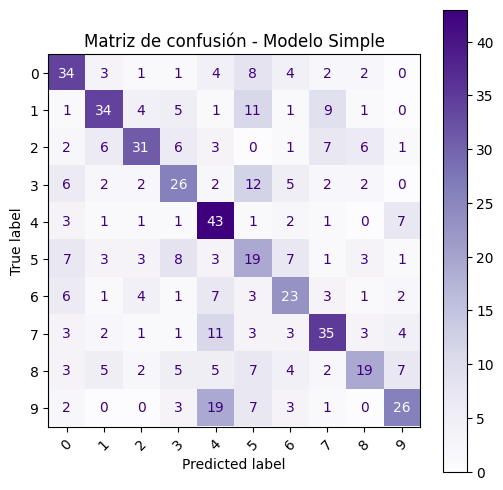

In [13]:
# =============================
# BLOQUE 4 - Modelo redes neuronales simples
# =============================

X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Construcción del modelo simple (sin convolución)
def build_simple_model(input_shape=(28*28,), num_classes=10):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

modelo3_Simple = build_simple_model()

# Entrenamiento
history= modelo3_Simple.fit(
    X_train_flat, y_train,
    validation_data=(X_val_flat, y_val),
    epochs=128,
    batch_size=64,
    verbose=1
)

history3_simple = history

# Predicciones
y_pred_probs_simple = modelo3_Simple.predict(X_test_flat)
y_pred3 = np.argmax(y_pred_probs_simple, axis=1)

# Gráfica de accuracy
plt.plot(history3_simple.history['accuracy'], label='Train Accuracy')
plt.plot(history3_simple.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento (modelo simple)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("-"*50)

# Matriz de confusión
y_test_classes = np.argmax(y_test, axis=1)
cm_simple = confusion_matrix(y_test_classes, y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_simple, display_labels=[str(i) for i in range(10)])
disp.plot(cmap='Purples', xticks_rotation=45)
plt.title("Matriz de confusión - Modelo Simple")
plt.show()


# Ejercicio 5

Accuracy del modelo SVM: 0.4633
              precision    recall  f1-score   support

           0       0.52      0.59      0.56        59
           1       0.70      0.63      0.66        67
           2       0.38      0.60      0.46        63
           3       0.36      0.46      0.40        59
           4       0.52      0.45      0.48        60
           5       0.43      0.29      0.35        55
           6       0.48      0.25      0.33        51
           7       0.49      0.52      0.50        66
           8       0.39      0.41      0.40        59
           9       0.43      0.36      0.39        61

    accuracy                           0.46       600
   macro avg       0.47      0.46      0.45       600
weighted avg       0.47      0.46      0.46       600



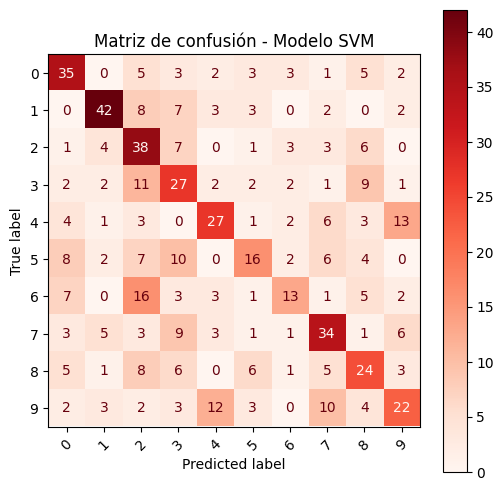

In [14]:
# =============================
# BLOQUE 5 - Modelo SVM
# =============================

X_train_flat_svm = X_train.reshape(len(X_train), -1)
X_test_flat_svm = X_test.reshape(len(X_test), -1)
y_train_svm = np.argmax(y_train, axis=1)
y_test_svm = np.argmax(y_test, axis=1)

sample_size = 3000
X_train_sample = X_train_flat_svm[:sample_size]
y_train_sample = y_train_svm[:sample_size]

modelo4_SVM = SVC(kernel='rbf', gamma=0.05)
modelo4_SVM.fit(X_train_sample, y_train_sample)

y_pred4 = modelo4_SVM.predict(X_test_flat_svm)

acc_svm = accuracy_score(y_test_svm, y_pred4)
print(f"Accuracy del modelo SVM: {acc_svm:.4f}")

# Reporte de clasificación
print(classification_report(y_test_svm, y_pred4))

# Matriz de confusión
cm_svm = confusion_matrix(y_test_svm, y_pred4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap='Reds', xticks_rotation=45)
plt.title("Matriz de confusión - Modelo SVM")
plt.show()

# Ejercicio 6

Epoch 1/21


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 525ms/step - accuracy: 0.0852 - loss: 2.3373 - val_accuracy: 0.1100 - val_loss: 2.3022
Epoch 2/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - accuracy: 0.1214 - loss: 2.3021 - val_accuracy: 0.1100 - val_loss: 2.3017
Epoch 3/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 517ms/step - accuracy: 0.1119 - loss: 2.3020 - val_accuracy: 0.1100 - val_loss: 2.3014
Epoch 4/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 566ms/step - accuracy: 0.1211 - loss: 2.3018 - val_accuracy: 0.1100 - val_loss: 2.3011
Epoch 5/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 521ms/step - accuracy: 0.1171 - loss: 2.3016 - val_accuracy: 0.1100 - val_loss: 2.3008
Epoch 6/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 518ms/step - accuracy: 0.1111 - loss: 2.3002 - val_accuracy: 0.1100 - val_loss: 2.3006
Epoch 7/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 568ms/step - accuracy: 0.0957 - loss: 2.3001 - val_accuracy: 0.1100 - val_loss: 2.3005
Epoch 8/21
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 517ms/step - accuracy: 0.1010 - loss: 2.3025 - val_accuracy: 0.110

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


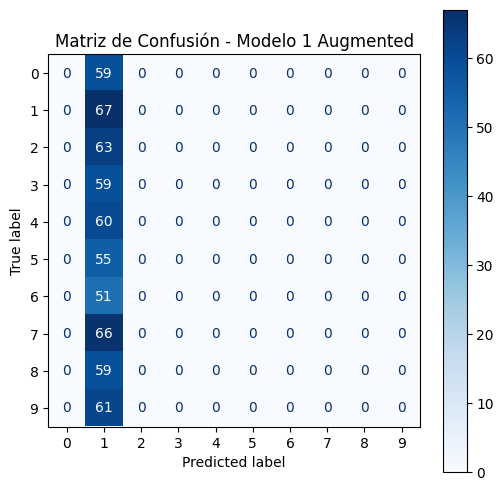

Epoch 1/32


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.0990 - loss: 2.3090 - val_accuracy: 0.1100 - val_loss: 2.3003
Epoch 2/32
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.1138 - loss: 2.3016 - val_accuracy: 0.1100 - val_loss: 2.2938
Epoch 3/32
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.1365 - loss: 2.2854 - val_accuracy: 0.3450 - val_loss: 2.0044
Epoch 4/32
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.3057 - loss: 1.9935 - val_accuracy: 0.5267 - val_loss: 1.3297
Epoch 5/32
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.4778 - loss: 1.5644 - val_accuracy: 0.7217 - val_loss: 0.9273
Epoch 6/32
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.5646 - loss: 1.2692 - val_accuracy: 0.7350 - val_loss: 0.8553
Epoch 7/32
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.6450 - loss: 1.0860 - val_accuracy: 0.8117 - val_loss: 0.6167
Epoch 8/32
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.6381 - loss: 1.0263 - val_accuracy: 0.8350 - val_

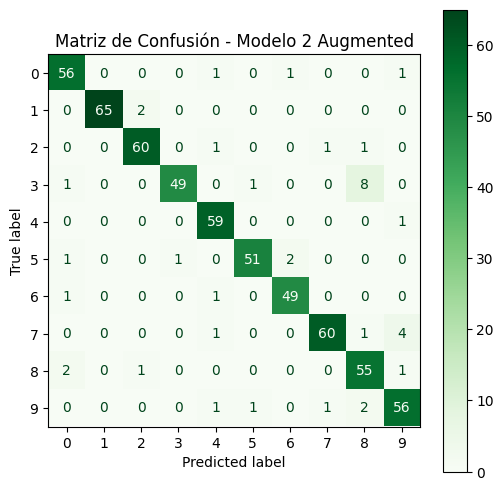

In [15]:
augmentador = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False
)

augmentador.fit(X_train)

# =============================
# BLOQUE 6.1 - Modelo 1 con Augmentation
# =============================

modelo1_aug = model_builder()

history_modelo1_aug = modelo1_aug.fit(
    augmentador.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=21,
    verbose=1
)

y_pred1_aug = modelo1_aug.predict(X_test)
y_pred1_aug = np.argmax(y_pred1_aug, axis=1)

print("Reporte - Modelo 1 con Augmentation")
print(classification_report(y_test_classes, y_pred1_aug))

cm1_aug = confusion_matrix(y_test_classes, y_pred1_aug)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1_aug, display_labels=[str(i) for i in range(10)])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Modelo 1 Augmented")
plt.show()

# =============================
# BLOQUE 6.2 - Modelo 2 con Augmentation
# =============================

modelo2_aug = model_builder_v2()

history_modelo2_aug = modelo2_aug.fit(
    augmentador.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=32,
    verbose=1
)

y_pred2_aug = modelo2_aug.predict(X_test)
y_pred2_aug = np.argmax(y_pred2_aug, axis=1)

print("Reporte - Modelo 2 con Augmentation")
print(classification_report(y_test_classes, y_pred2_aug))

cm2_aug = confusion_matrix(y_test_classes, y_pred2_aug)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2_aug, display_labels=[str(i) for i in range(10)])
disp.plot(cmap='Greens')
plt.title("Matriz de Confusión - Modelo 2 Augmented")
plt.show()

# Ejercicio 7

In [31]:
from google.colab import files
import zipfile
import os

# Subir archivo .zip con imágenes manuscritas
uploaded = files.upload()

# Extraer ZIP en carpeta "imagenes_digitos"
for fname in uploaded.keys():
    if fname.endswith(".zip"):
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall("imagenes_digitos")
        print("Descompresión completada.")

# Verifica contenido extraído
for root, dirs, files in os.walk("imagenes_digitos"):
    for name in files:
        print(os.path.join(root, name))

Saving Imagenes lab Data Science.zip to Imagenes lab Data Science (3).zip
Descompresión completada.
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._digito 5.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._digito 9.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._IMG_0F4296CB74D1-1.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._IMG_477DAC849A67-1.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._IMG_4DFDE736BF08-1.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._IMG_BD892AD005BB-1.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._digito 4.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._IMG_C1D2D6722E16-1.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._digito 0.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._Imagen JPEG-467F-8574-B4-0.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._IMG_8A58CC9B250C-1.jpeg
imagenes_digitos/__MACOSX/Imagenes lab Data Science/._IMG_29EF67EB35B8-1.j

In [32]:
import glob

# Buscar imágenes dentro de "Imagenes lab Data Science"
rutas_imagenes = glob.glob("imagenes_digitos/Imagenes lab Data Science/*.jpeg") + \
                 glob.glob("imagenes_digitos/Imagenes lab Data Science/*.jpg") + \
                 glob.glob("imagenes_digitos/Imagenes lab Data Science/*.png")

print(f"Se encontraron {len(rutas_imagenes)} imágenes.")
print(rutas_imagenes)  # Para verificar todas las rutas encontradas

Se encontraron 20 imágenes.
['imagenes_digitos/Imagenes lab Data Science/digito 6.jpeg', 'imagenes_digitos/Imagenes lab Data Science/digito 7.jpeg', 'imagenes_digitos/Imagenes lab Data Science/digito 3.jpeg', 'imagenes_digitos/Imagenes lab Data Science/Imagen JPEG-467F-8574-B4-0.jpeg', 'imagenes_digitos/Imagenes lab Data Science/IMG_513103FD4896-1.jpeg', 'imagenes_digitos/Imagenes lab Data Science/IMG_BD892AD005BB-1.jpeg', 'imagenes_digitos/Imagenes lab Data Science/IMG_E0761925CFAF-1.jpeg', 'imagenes_digitos/Imagenes lab Data Science/IMG_4DFDE736BF08-1.jpeg', 'imagenes_digitos/Imagenes lab Data Science/digito 5.jpeg', 'imagenes_digitos/Imagenes lab Data Science/IMG_477DAC849A67-1.jpeg', 'imagenes_digitos/Imagenes lab Data Science/digito 8.jpeg', 'imagenes_digitos/Imagenes lab Data Science/digito 0.jpeg', 'imagenes_digitos/Imagenes lab Data Science/digito 4.jpeg', 'imagenes_digitos/Imagenes lab Data Science/digito 2.jpeg', 'imagenes_digitos/Imagenes lab Data Science/IMG_29EF67EB35B8-1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


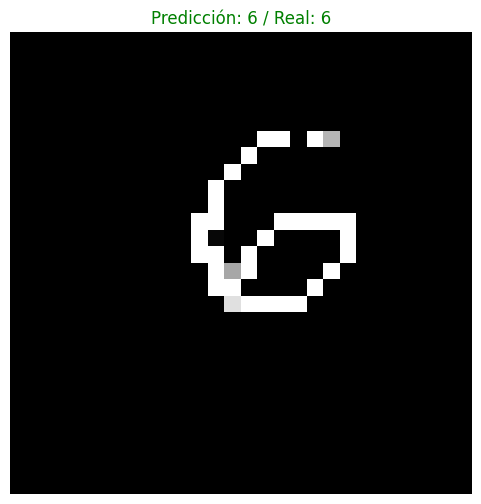

digito 6.jpeg → Predicho: 6 / Real: 6 → Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


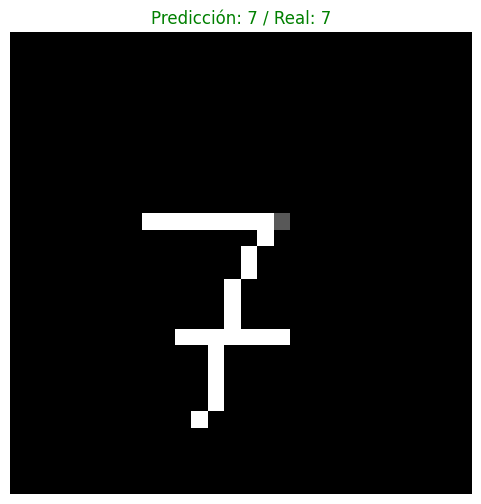

digito 7.jpeg → Predicho: 7 / Real: 7 → Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


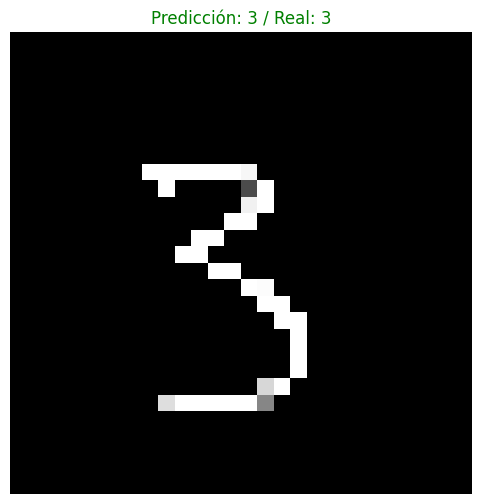

digito 3.jpeg → Predicho: 3 / Real: 3 → Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


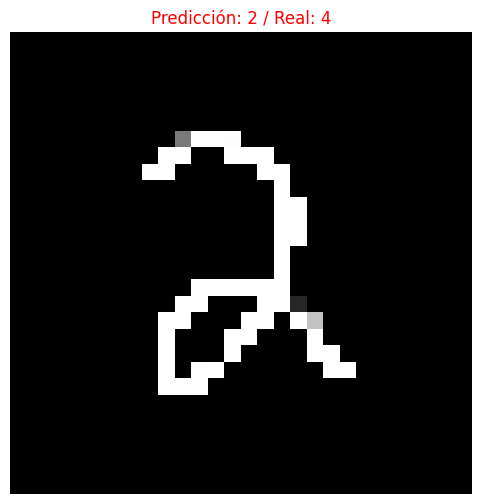

Imagen JPEG-467F-8574-B4-0.jpeg → Predicho: 2 / Real: 4 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


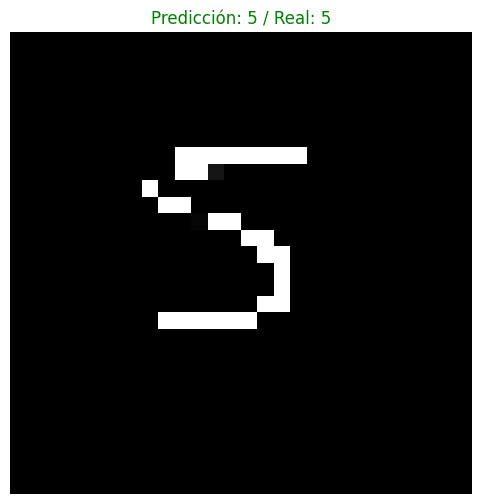

IMG_513103FD4896-1.jpeg → Predicho: 5 / Real: 5 → Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


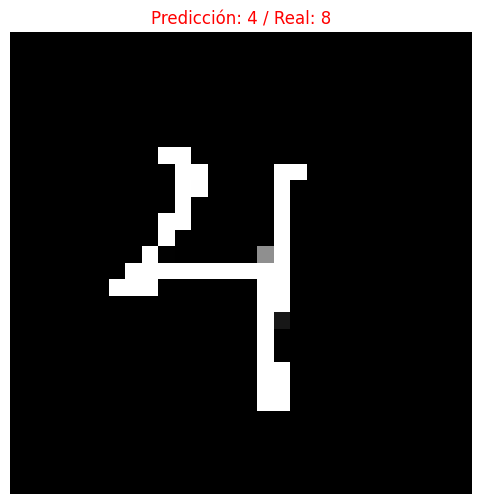

IMG_BD892AD005BB-1.jpeg → Predicho: 4 / Real: 8 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


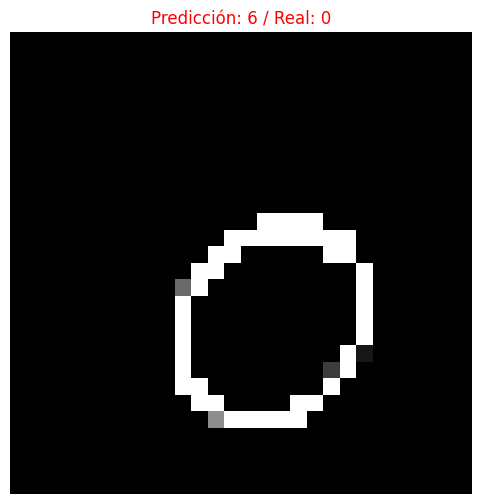

IMG_E0761925CFAF-1.jpeg → Predicho: 6 / Real: 0 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


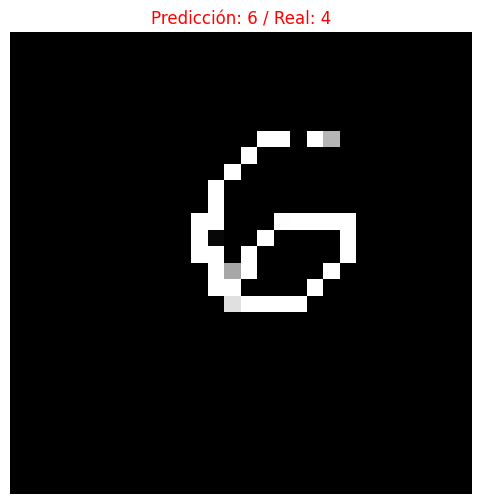

IMG_4DFDE736BF08-1.jpeg → Predicho: 6 / Real: 4 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


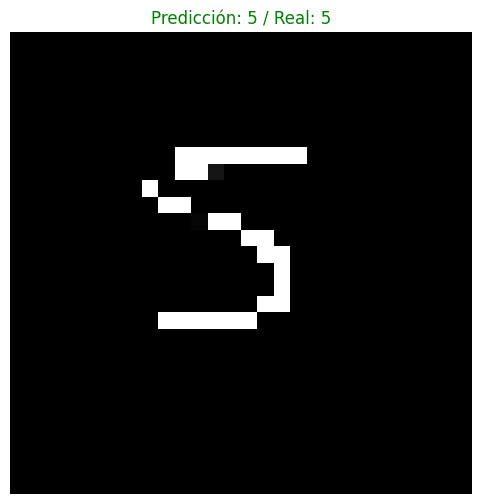

digito 5.jpeg → Predicho: 5 / Real: 5 → Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


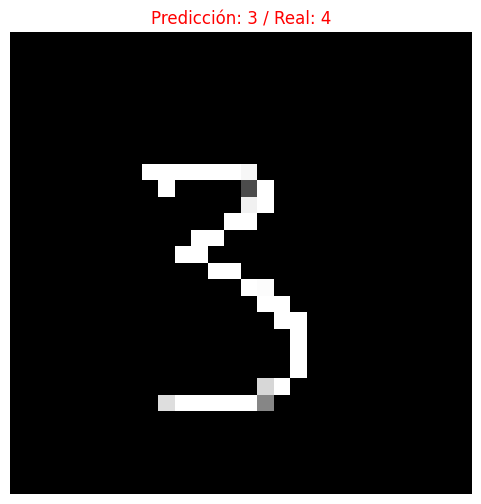

IMG_477DAC849A67-1.jpeg → Predicho: 3 / Real: 4 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


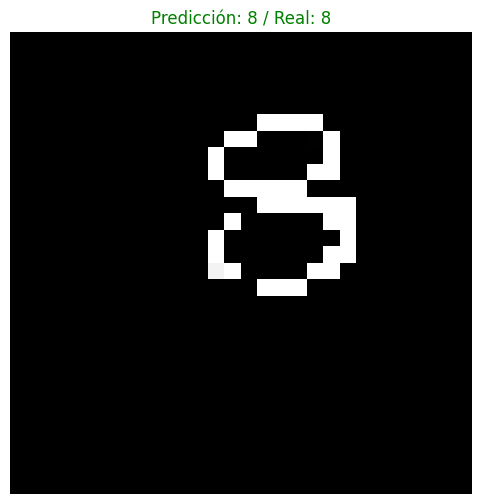

digito 8.jpeg → Predicho: 8 / Real: 8 → Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


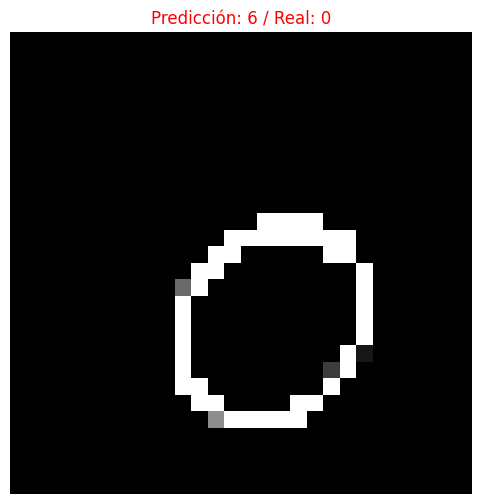

digito 0.jpeg → Predicho: 6 / Real: 0 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


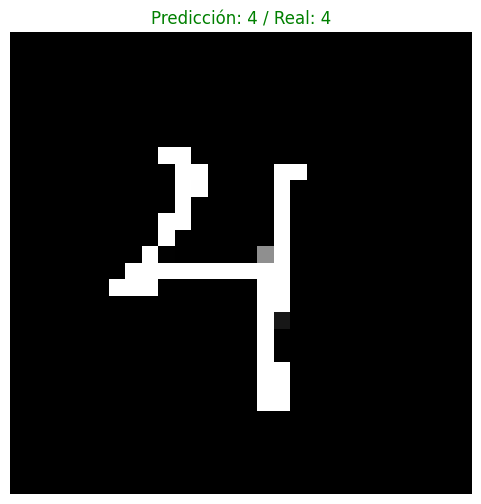

digito 4.jpeg → Predicho: 4 / Real: 4 → Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


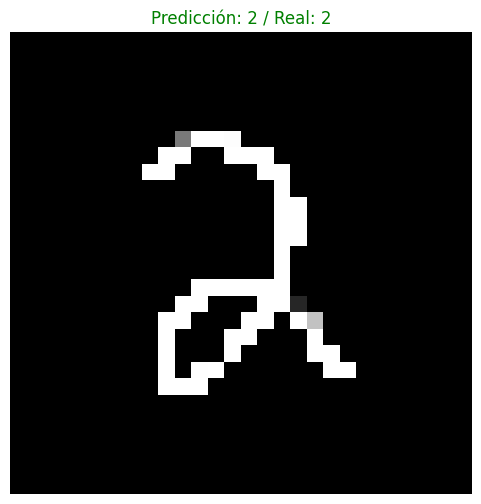

digito 2.jpeg → Predicho: 2 / Real: 2 → Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


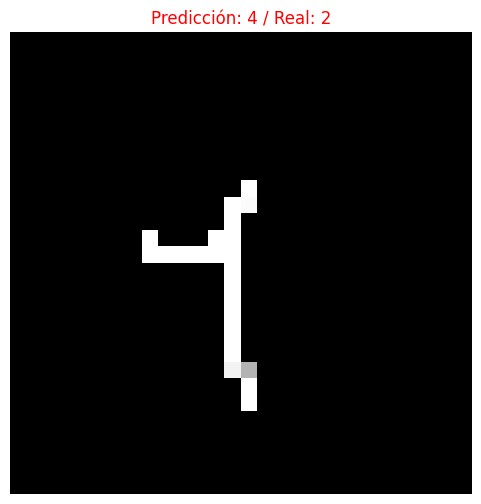

IMG_29EF67EB35B8-1.jpeg → Predicho: 4 / Real: 2 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


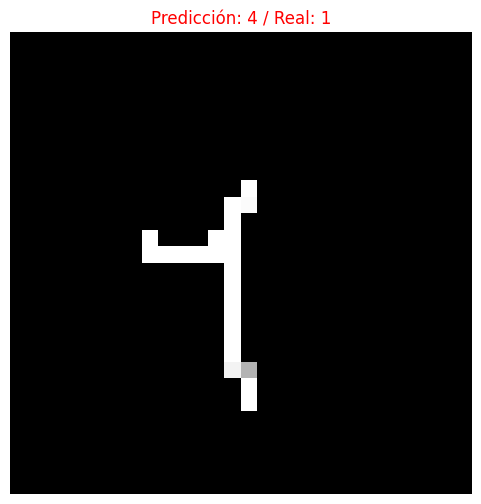

digito 1.jpeg → Predicho: 4 / Real: 1 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


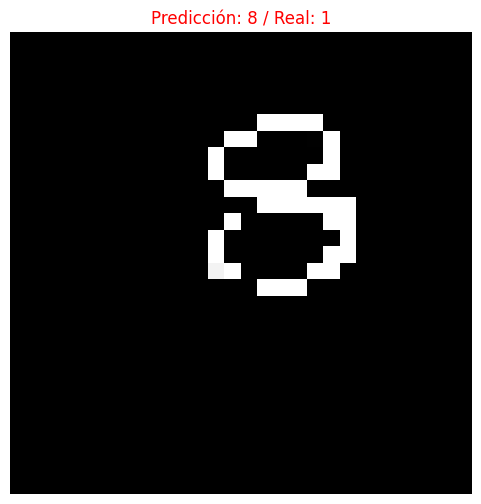

IMG_C1D2D6722E16-1.jpeg → Predicho: 8 / Real: 1 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


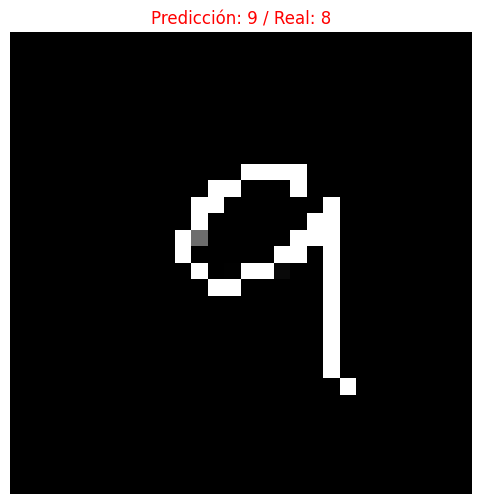

IMG_8A58CC9B250C-1.jpeg → Predicho: 9 / Real: 8 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


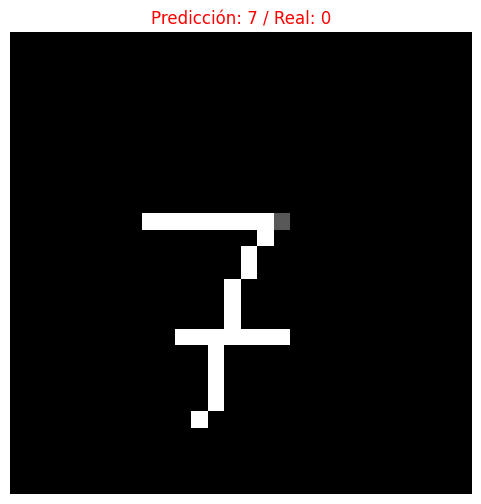

IMG_0F4296CB74D1-1.jpeg → Predicho: 7 / Real: 0 → Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


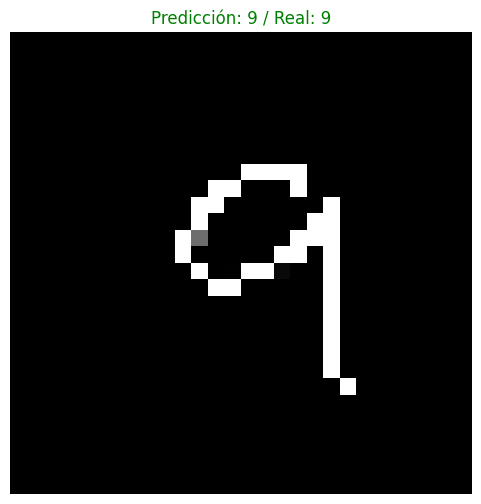

digito 9.jpeg → Predicho: 9 / Real: 9 → Correcto

Accuracy en tus imágenes reales: 9 de 20 → 45.00%


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Función de preprocesamiento
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    if np.mean(img) > 127:
        img = 255 - img  # invertir si fondo es blanco
    img = img.astype("float32") / 255.0
    return img.reshape(1, 28, 28, 1)

# Evaluación
total = 0
aciertos = 0

for ruta in rutas_imagenes:
    img_proc = preprocess_image(ruta)
    pred = modelo2_aug.predict(img_proc)
    pred_clase = np.argmax(pred)

    # Extraer etiqueta esperada desde el nombre (e.g., "digito 4.jpeg" → 4)
    nombre = os.path.basename(ruta)
    match = re.search(r'\d', nombre)
    if match:
        real_clase = int(match.group())
    else:
        print(f"No se pudo determinar la clase real desde el nombre: {nombre}")
        continue

    total += 1
    correcto = (pred_clase == real_clase)
    if correcto:
        aciertos += 1

    # Mostrar imagen con resultado
    plt.imshow(img_proc.reshape(28, 28), cmap='gray')
    color = 'green' if correcto else 'red'
    plt.title(f"Predicción: {pred_clase} / Real: {real_clase}", color=color)
    plt.axis('off')
    plt.show()

    estado = "Correcto" if correcto else "Incorrecto"
    print(f"{nombre} → Predicho: {pred_clase} / Real: {real_clase} → {estado}")

# Mostrar accuracy final
print(f"\nAccuracy en tus imágenes reales: {aciertos} de {total} → {aciertos/total:.2%}")